# EDA 
**How to use**
1. Open this file in Jupyter / JupyterLab / Colab.  
2. Run cells *top to bottom* (Kernel: Python 3.10+ recommended).  
3. When running data fetch cells you'll need internet for `yfinance`; if offline, use the backup CSV path provided in the CONFIG cell.
4. Presentation tip: For each plot, read the short interpretation prompts provided below the plot cells.


In [ ]:
# 1. Setup & Imports
import os                               # File system operations
import pandas as pd                     # Data handling
import numpy as np                      # Numerical operations
import matplotlib.pyplot as plt         # Plotting
import seaborn as sns                   # Advanced visualization
import yfinance as yf                   # Fetch stock data
import pandas_market_calendars as mcal  # Market trading calendar
from datetime import datetime
from scipy import stats                 # Z-score / statistical functions
import plotly.graph_objects as go
import plotly.express as px


# Display & Plotting settings
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")

# display inline (Jupyter)
%matplotlib inline

print("Packages imported. Matplotlib inline ready.")

Packages imported. Matplotlib inline ready.


## 2) Configuration
Edit `CONFIG` below for tickers, date range, and file paths. For presentations it's convenient to keep defaults,
but you can change tickers or dates interactively.


In [2]:
# 2) Configuration (edit if needed)
CONFIG = {
    "tickers": ["AAPL", "MSFT", "GOOGL", "JPM", "TSLA"],
    "start_date": "2022-01-01",
    "end_date": "2025-01-01",
    "backup_path": "data/backup_stocks.csv",
    "output_long": "data/cleaned_stock_data_long.csv",
    "output_wide": "data/cleaned_stock_data_wide.csv",
}
CONFIG

{'tickers': ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'TSLA'],
 'start_date': '2022-01-01',
 'end_date': '2025-01-01',
 'backup_path': 'data/backup_stocks.csv',
 'output_long': 'data/cleaned_stock_data_long.csv',
 'output_wide': 'data/cleaned_stock_data_wide.csv'}

## 3) Data Acquisition
This cell defines `fetch_stock_data()` which uses `yfinance` and falls back to a CSV if `yfinance` fails.
Run the cell to fetch data (or, if offline, ensure backup CSV exists).

In [3]:
def fetch_stock_data(tickers, start, end, backup_path):
    """Fetch historical stock data from yfinance (multi-ticker) with CSV fallback."""
    try:
        # Validate input
        if not tickers:
            raise ValueError("No tickers provided")

        # Attempt to fetch from yfinance
        data = yf.download(
            tickers,
            start=start,
            end=end,
            group_by="ticker",
            auto_adjust=True,
            progress=False
        )

        if data.empty:
            raise ValueError("Empty response from yfinance")

        print(f"Data fetched for {len(tickers) if isinstance(tickers, list) else 1} "
              f"ticker(s): {start} → {end}")
        return data

    except Exception as e:
        # Fallback to backup CSV if API call fails
        print(f"yfinance failed: {e}. Loading backup CSV: {backup_path}")
        return pd.read_csv(backup_path, parse_dates=['Date'])


# Example usage (uncomment to run in notebook)
raw_data = fetch_stock_data(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'], CONFIG['backup_path'])
raw_data.head()

Data fetched for 5 ticker(s): 2022-01-01 → 2025-01-01


Ticker            TSLA                                                 \
Price             Open        High         Low       Close     Volume   
Date                                                                    
2022-01-03  382.583344  400.356659  378.679993  399.926666  103931400   
2022-01-04  396.516663  402.666656  374.350006  383.196655  100248300   
2022-01-05  382.216675  390.113342  360.336670  362.706665   80119800   
2022-01-06  359.000000  362.666656  340.166656  354.899994   90336600   
2022-01-07  360.123322  360.309998  336.666656  342.320007   84164700   

Ticker           GOOGL                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  144.061394  144.851946  142.728591  143.998337  28646000   
2022-01-04  144.400050  145.481595  142.732065  143.410385  28400000   
2022-01-05  143.430740  143.509694  136.744859  136.831253  54618000   
2022-01-06  136.060093  138.981442  135.623104  136.803955  37348000   
2022-01-07  137.199225  137.500158  134.836523  136.078461  29760000   

Ticker            MSFT                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  325.086189  327.655077  319.686659  324.504547  28865100   
2022-01-04  324.582065  324.940765  316.138654  318.940216  32674300   
2022-01-05  315.886642  316.090236  306.309056  306.696808  40054300   
2022-01-06  303.565708  308.945862  301.956511  304.273376  39646100   
2022-01-07  304.534964  306.813044  300.599229  304.428345  32720000   

Ticker             JPM                                                \
Price             Open        High         Low       Close    Volume   
Date                                                                   
2022-01-03  144.626359  147.141442  144.309706  146.291016  13120900   
2022-01-04  148.652328  152.515429  148.579950  151.836899  20195800   
2022-01-05  152.737936  153.229399  149.015495  149.061005  17539400   
2022-01-06  151.909702  152.328354  149.142901  150.644623  14047500   
2022-01-07  150.781140  152.473981  150.225960  152.137238  13913300   

Ticker            AAPL                                                 
Price             Open        High         Low       Close     Volume  
Date                                                                   
2022-01-03  174.345053  179.296091  174.227410  178.443130  104487900  
2022-01-04  179.050979  179.354901  175.609755  176.178391   99310400  
2022-01-05  176.090173  176.639196  171.217569  171.492081   94537600  
2022-01-06  169.315597  171.864651  168.276373  168.629318   96904000  
2022-01-07  169.501881  170.727385  167.678331  168.795990   86709100

## 4) Cleaning functions
Contains `clean_stock_data()` and `clean_all_tickers()` — robust cleaning, normalize dates, handle missing values, enforce numeric types.


In [4]:
# 4. Data Cleaning
def clean_stock_data(df: pd.DataFrame, ticker: str) -> pd.DataFrame:
    """
    Clean stock data for a single ticker.
    
    Steps:
        - Ensure required columns are present
        - Normalize and sort by date
        - Handle missing values (drop if >50%, else forward/backward fill)
        - Drop duplicates and enforce numeric dtypes
        - Validate constraints (non-negative prices, volumes and valid dates)
    """
    df = df.copy().reset_index()
    df["Ticker"] = ticker

    # Validate inputs and check required columns
    required_cols = ["Date", "Open", "High", "Low", "Close", "Volume"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column '{col}' for {ticker}")

    if df.empty:
        raise ValueError(f"No data available for {ticker}")

    # Normalize and sort dates
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df.sort_values("Date", inplace=True)

    # Handle missing values (drop if >50% columns missing, else fill)
    core_cols = ["Open", "High", "Low", "Close", "Volume"]
    missing_pct = df[core_cols].isnull().mean(axis=1)
    df = df[missing_pct < 0.5] # Drop rows with excessive missing values

    # Fill remaining missing values using forward/backward fill
    df = df.ffill().bfill() 

    # Drop duplicate dates
    df.drop_duplicates(subset=["Date"], inplace=True)

    # Ensure numeric types
    for col in core_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Validation: no negative values
    if (df[["Open", "High", "Low", "Close"]] < 0).any().any():
        raise ValueError(f"Negative prices detected for {ticker}")
    if (df["Volume"] < 0).any():
        raise ValueError(f"Negative volumes detected for {ticker}")

    # Reset index after cleaning
    df.reset_index(drop=True, inplace=True)

    return df


def clean_all_tickers(raw_data: pd.DataFrame, tickers: list[str]) -> pd.DataFrame:
    """
    Clean stock data for multiple tickers and combine into a single DataFrame.
    """
    cleaned_list = []

    for t in tickers:
        try:
            temp = raw_data[t].reset_index()
            cleaned = clean_stock_data(temp, t)
            cleaned_list.append(cleaned)
            print(f"{t} cleaned successfully ({len(cleaned)} rows).")
        except Exception as e:
            print(f"Error processing {t}: {e}")

    combined = pd.concat(cleaned_list, ignore_index=True)

    # Drop extra 'index' column if present
    if "index" in combined.columns:
        combined.drop(columns=["index"], inplace=True)

    return combined


# Example usage (uncomment to run after fetching data)
cleaned_data = clean_all_tickers(raw_data, CONFIG["tickers"])
print(f"Final cleaned dataset shape: {cleaned_data.shape}")
cleaned_data.head()


AAPL cleaned successfully (753 rows).
MSFT cleaned successfully (753 rows).
GOOGL cleaned successfully (753 rows).
JPM cleaned successfully (753 rows).
TSLA cleaned successfully (753 rows).
Final cleaned dataset shape: (3765, 7)


Price,Date,Open,High,Low,Close,Volume,Ticker
0,2022-01-03,174.345053,179.296091,174.227410,178.443130,104487900,AAPL
1,2022-01-04,179.050979,179.354901,175.609755,176.178391,99310400,AAPL
2,2022-01-05,176.090173,176.639196,171.217569,171.492081,94537600,AAPL
3,2022-01-06,169.315597,171.864651,168.276373,168.629318,96904000,AAPL
4,2022-01-07,169.501881,170.727385,167.678331,168.795990,86709100,AAPL


## 5) Trading day alignment & Outlier detection
Align data with NYSE trading calendar and detect outliers using Z-score and IQR.


In [5]:
def align_with_trading_days(df: pd.DataFrame, start: str, end: str) -> pd.DataFrame:
    """
    Align stock data with official NYSE trading days.
    """
    nyse = mcal.get_calendar("NYSE")
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days = schedule.index.normalize()

    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"]).dt.normalize()
    df = df[df["Date"].isin(trading_days)]

    print(f"Data aligned with NYSE trading days "
          f"({trading_days.min().date()} → {trading_days.max().date()})")
    return df


# Example usage (after cleaning):
cleaned_data = align_with_trading_days(cleaned_data, CONFIG['start_date'], CONFIG['end_date'])


Data aligned with NYSE trading days (2022-01-03 → 2024-12-31)


In [6]:
def detect_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    Detect outliers in daily returns using Z-score and IQR.
    
    Adds:
        - Daily_Return
        - Z_Score
        - Outlier_Z
        - Outlier_IQR
    """
    df = df.copy()
    
    # Daily returns
    df["Daily_Return"] = df.groupby("Ticker")["Close"].pct_change()

    # Z-score method
    df["Z_Score"] = df.groupby("Ticker")["Daily_Return"].transform(
        lambda x: stats.zscore(x, nan_policy="omit")
    )
    df["Outlier_Z"] = df["Z_Score"].abs() > 3

    # IQR method
    def iqr_outliers(series):
        q1, q3 = np.nanpercentile(series, [25, 75])
        iqr = q3 - q1
        return (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))

    df["Outlier_IQR"] = df.groupby("Ticker")["Daily_Return"].transform(iqr_outliers)

    print("Outlier detection completed (Z-score & IQR).")
    return df

# Example usage (after cleaning):
cleaned_data = detect_outliers(cleaned_data)
cleaned_data.head()

Outlier detection completed (Z-score & IQR).


Price,Date,Open,High,Low,Close,Volume,Ticker,Daily_Return,Z_Score,Outlier_Z,Outlier_IQR
0,2022-01-03,174.345053,179.296091,174.227410,178.443130,104487900,AAPL,NaN,NaN,False,False
1,2022-01-04,179.050979,179.354901,175.609755,176.178391,99310400,AAPL,-0.012692,-0.778777,False,False
2,2022-01-05,176.090173,176.639196,171.217569,171.492081,94537600,AAPL,-0.026600,-1.594219,False,False
3,2022-01-06,169.315597,171.864651,168.276373,168.629318,96904000,AAPL,-0.016693,-1.013394,False,False
4,2022-01-07,169.501881,170.727385,167.678331,168.795990,86709100,AAPL,0.000988,0.023292,False,False


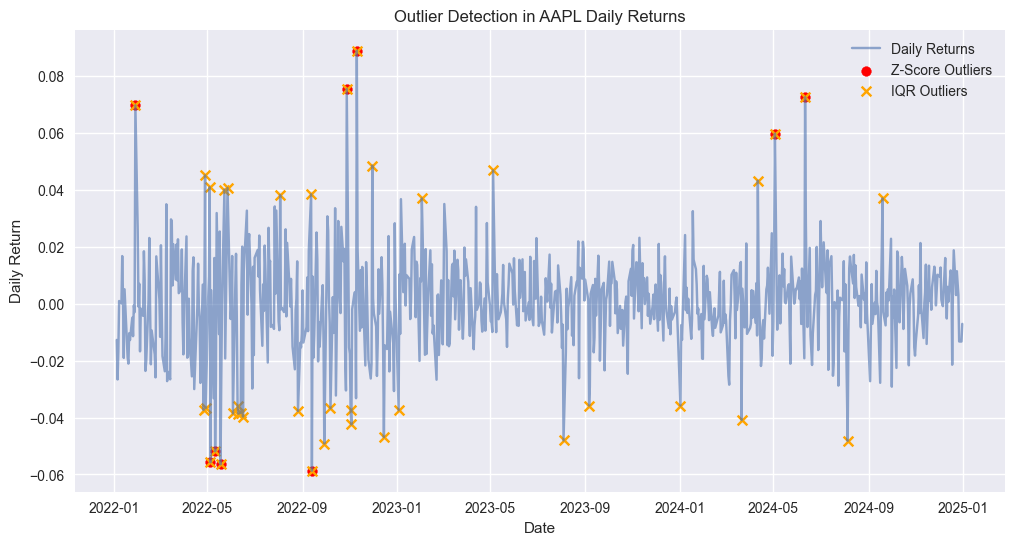

In [7]:
def plot_outliers(df: pd.DataFrame, tickers: list[str] | str):
    """
    Plot daily returns and highlight outliers for one or more tickers.
    """
    if isinstance(tickers, str):
        tickers = [tickers]

    for ticker in tickers:
        subset = df[df["Ticker"] == ticker]
        plt.figure(figsize=(12, 6))
        plt.plot(subset["Date"], subset["Daily_Return"], label="Daily Returns", alpha=0.6)
        plt.scatter(subset["Date"][subset["Outlier_Z"]],
                    subset["Daily_Return"][subset["Outlier_Z"]],
                    color="red", label="Z-Score Outliers")
        plt.scatter(subset["Date"][subset["Outlier_IQR"]],
                    subset["Daily_Return"][subset["Outlier_IQR"]],
                    color="orange", marker="x", label="IQR Outliers")

        plt.title(f"Outlier Detection in {ticker} Daily Returns")
        plt.xlabel("Date")
        plt.ylabel("Daily Return")
        plt.legend()
        plt.show()

# Example: Plot for all tickers in a loop
plot_outliers(cleaned_data, ["AAPL"]) 
# plot_outliers(cleaned_data, ["AAPL", "JPM"])  # Tech & Finance examples

## 6) Data quality report & validation
A short per-ticker report and automated validation tests.


In [8]:
# 6. Data Quality & Validation

def data_quality_report(df: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a data quality report per ticker including:
        - Row count
        - Date range
        - Missing values %
        - Duplicate dates
        - Coverage of expected NYSE trading days
    """
    core_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    report = []
    nyse = mcal.get_calendar('NYSE')  # NYSE trading calendar

    # Group by ticker and calculate metrics
    for ticker, group in df.groupby('Ticker'):
        total_rows = len(group)
        
        # Missing values %
        missing_pct = (group[core_cols].isnull().sum().sum() / (total_rows * len(core_cols))) * 100
        
        # Duplicate date count
        duplicates = group.duplicated(subset=['Date']).sum()
        
        # Date range
        min_date, max_date = group['Date'].min(), group['Date'].max()
        
        # Trading days coverage
        schedule = nyse.schedule(start_date=min_date, end_date=max_date)
        expected_days = len(schedule)
        coverage_pct = (total_rows / expected_days) * 100 if expected_days > 0 else np.nan
        
        # Append metrics to report
        report.append({
            'Ticker': ticker,
            'Rows': total_rows,
            'Date Range': f'{min_date.date()} → {max_date.date()}',
            'Missing %': f'{missing_pct:.2f}%',
            'Duplicates': duplicates,
            'Coverage %': f'{coverage_pct:.2f}%'
        })
    
    return pd.DataFrame(report)

# Example usage (after cleaning and outlier detection)
report = data_quality_report(cleaned_data)
print("Data Quality Report")
display(report)  # Display summary table

Data Quality Report


,Ticker,Rows,Date Range,Missing %,Duplicates,Coverage %
0,AAPL,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
1,GOOGL,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
2,JPM,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
3,MSFT,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%
4,TSLA,753,2022-01-03 → 2024-12-31,0.00%,0,100.00%


In [9]:
# 9. Validation Tests
def validate_preprocessing(df: pd.DataFrame, start_date: str, end_date: str):
    """
    Perform automated checks to ensure preprocessing correctness:
        1. No missing core values
        2. Daily returns computed correctly
        3. Non-negative prices
        4. No duplicate dates
        5. Date ranges within bounds
    """
    # 1. Missing values
    assert df[["Open", "High", "Low", "Close", "Volume"]].isnull().sum().sum() == 0, \
        "Missing values remain!"

    # 2. Daily returns consistency
    for ticker in df["Ticker"].unique():
        subset = df[df["Ticker"] == ticker]
        expected_returns = subset["Close"].pct_change()
        assert np.allclose(subset["Daily_Return"].dropna(), expected_returns.dropna(), equal_nan=True), \
            f"Daily returns mismatch for {ticker}"

    # 3. Non-negative prices
    assert (df[["Open", "High", "Low", "Close"]] >= 0).all().all(), "Negative prices detected!"

    # 4. No duplicates
    for ticker, group in df.groupby("Ticker"):
        assert not group["Date"].duplicated().any(), f"Duplicates found in {ticker}"

    # 5. Date range validation
    for ticker, group in df.groupby("Ticker"):
        assert group['Date'].min() >= pd.to_datetime(start_date), f'Start date invalid for {ticker}'
        assert group['Date'].max() <= pd.to_datetime(end_date), f'End date invalid for {ticker}'

    print("Preprocessing validations passed!")


# Run validation checks
validate_preprocessing(cleaned_data, CONFIG['start_date'], CONFIG['end_date'])

Preprocessing validations passed!


## 7) Pivot to wide format & basic statistics
Create a pivot table of Close prices and compute mean/volatility/skew/kurtosis/sharpe.


In [10]:
def pivot_wide(df):
    pivot = df.pivot(index='Date', columns='Ticker', values='Close').ffill().bfill()
    return pivot

def compute_stats(pivot):
    daily_returns = pivot.pct_change().dropna()
    stats_df = pd.DataFrame({
        'Ticker': daily_returns.columns,
        'Mean Return': daily_returns.mean(),
        'Volatility (Std)': daily_returns.std(),
        'Min Return': daily_returns.min(),
        'Max Return': daily_returns.max(),
        'Skewness': daily_returns.skew(),
        'Kurtosis': daily_returns.kurtosis(),
        'Sharpe (approx)': daily_returns.mean()/daily_returns.std()
    }).reset_index(drop=True)
    return stats_df

# Example usage:
pivot = pivot_wide(cleaned_data)
stats_df = compute_stats(pivot)
stats_df

,Ticker,Mean Return,Volatility (Std),Min Return,Max Return,Skewness,Kurtosis,Sharpe (approx)
0,AAPL,0.000591,0.017067,-0.058680,0.088974,0.213376,2.514823,0.034635
1,GOOGL,0.000572,0.020627,-0.095094,0.102243,0.013492,2.727510,0.027731
2,JPM,0.000759,0.015743,-0.064678,0.115445,0.398059,5.741126,0.048196
3,MSFT,0.000491,0.017372,-0.077156,0.082268,0.009359,1.955804,0.028278
4,TSLA,0.000755,0.038618,-0.123346,0.219190,0.245814,2.193303,0.019547


## 8) Visualizations (presentation-ready)
Plot price series, SMAs, rolling volatility, correlation heatmap, boxplots, and outlier visualisations.
Each plot cell includes a short presenter note you can read aloud.


In [11]:
# Pivot cleaned_data to wide format
pivot = cleaned_data.pivot(index='Date', columns='Ticker', values='Close').ffill().bfill().reset_index()

# Calculate SMAs for AAPL (example)
pivot['SMA_20'] = pivot['AAPL'].rolling(20).mean()
pivot['SMA_50'] = pivot['AAPL'].rolling(50).mean()

In [12]:
import plotly.graph_objects as go
import numpy as np

def plot_price_sma_eda(dates, prices, smas, ticker="AAPL", title="Price with SMA Overlay"):
    fig = go.Figure()

    # === Closing Price Line ===
    fig.add_trace(go.Scatter(
        x=dates,
        y=prices,
        mode='lines',
        name=f'{ticker} Close',
        line=dict(color='green', width=2),
        hovertemplate='Date: %{x}<br>Close: %{y:.2f}<extra></extra>'
    ))

    # === SMA Lines ===
    colors = ['blue', 'orange', 'purple', 'red']  # distinct colors for multiple SMAs
    for i, sma in enumerate(smas):
        fig.add_trace(go.Scatter(
            x=dates,
            y=sma,
            mode='lines',
            name=sma.name,
            line=dict(width=2, dash='dash', color=colors[i % len(colors)]),
            hovertemplate=f'Date: %{{x}}<br>{sma.name}: %{{y:.2f}}<extra></extra>'
        ))

    # === Highlight SMA Crossovers ===
    if len(smas) >= 2:
        diff = smas[0] - smas[1]
        crossover_indices = np.where(np.sign(diff) != np.sign(diff.shift(1)))[0]
        fig.add_trace(go.Scatter(
            x=dates[crossover_indices],
            y=prices.iloc[crossover_indices],
            mode='markers',
            name='Crossover',
            marker=dict(size=8, color='red', symbol='x'),
            hovertemplate='Crossover: %{x}<br>Price: %{y:.2f}<extra></extra>'
        ))

    # === Layout for EDA Readability ===
    fig.update_layout(
        title=dict(
            text=f"{ticker} {title}<br><sup>{dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}</sup>",
            x=0.5,
            font=dict(size=22)
        ),
        xaxis_title='Date',
        yaxis_title='Price (USD)',
        template='plotly_white',
        hovermode='x unified',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        margin=dict(l=40, r=40, t=100, b=40),
        height=600
    )

    fig.show()


# === Example usage ===
sma_list = [pivot['SMA_20'], pivot['SMA_50']]
for s in sma_list:
    s.name = s.name  # ensure each series has a name

plot_price_sma_eda(pivot['Date'], pivot['AAPL'], sma_list, ticker="AAPL", title="Price with 20 & 50 SMA")


In [13]:
def highlight_streaks_notebook(df, price_cols, date_col='Date', title="Price Streaks"):
    fig = go.Figure()

    for price_col in price_cols:
        change = df[price_col].diff().fillna(0)
        for i in range(1, len(df)):
            color = 'green' if change.iloc[i] > 0 else ('red' if change.iloc[i] < 0 else 'blue')
            fig.add_trace(go.Scatter(
                x=df[date_col].iloc[i-1:i+1],
                y=df[price_col].iloc[i-1:i+1],
                mode='lines',
                line=dict(color=color, width=3),
                showlegend=False
            ))

    fig.update_layout(title=dict(text=title, x=0.5, font=dict(size=22)),
                      xaxis_title='Date', yaxis_title='Price', template='plotly_white', width=1200, height=600)
    fig.show()

# List of stocks to highlight streaks
stocks_to_plot = ['AAPL', 'MSFT', 'GOOGL']  # add any available tickers in your pivot
highlight_streaks_notebook(pivot, stocks_to_plot, date_col='Date', title="Stock Price Streaks")


In [14]:
def annotate_profits_notebook(df, prices, sma, date_col='Date', title="Buy/Sell Signals"):
    buy_signals, sell_signals = [], []
    flag = -1
    for i in range(len(df)):
        if df[prices].iloc[i] > df[sma].iloc[i]:
            if flag != 1:
                buy_signals.append(df[prices].iloc[i])
                sell_signals.append(None)
                flag = 1
            else:
                buy_signals.append(None)
                sell_signals.append(None)
        elif df[prices].iloc[i] < df[sma].iloc[i]:
            if flag != 0:
                buy_signals.append(None)
                sell_signals.append(df[prices].iloc[i])
                flag = 0
            else:
                buy_signals.append(None)
                sell_signals.append(None)
        else:
            buy_signals.append(None)
            sell_signals.append(None)

    df['Buy'] = buy_signals
    df['Sell'] = sell_signals

    fig = go.Figure()

    # Price Line
    fig.add_trace(go.Scatter(
        x=df[date_col], y=df[prices],
        mode='lines', name='Close Price',
        line=dict(color='blue', width=2)
    ))

    # SMA Line
    fig.add_trace(go.Scatter(
        x=df[date_col], y=df[sma],
        mode='lines', name=sma,
        line=dict(color='orange', width=2, dash='dash')
    ))

    # Buy Signals (green dots)
    fig.add_trace(go.Scatter(
        x=df[date_col], y=df['Buy'],
        mode='markers',
        name='Buy Signal',
        marker=dict(symbol='circle', color='green', size=8, opacity=0.9),
        hovertemplate='Buy Signal<br>Date: %{x}<br>Price: %{y:.2f}<extra></extra>'
    ))

    # Sell Signals (red dots)
    fig.add_trace(go.Scatter(
        x=df[date_col], y=df['Sell'],
        mode='markers',
        name='Sell Signal',
        marker=dict(symbol='circle', color='red', size=8, opacity=0.9),
        hovertemplate='Sell Signal<br>Date: %{x}<br>Price: %{y:.2f}<extra></extra>'
    ))

    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=22)),
        xaxis_title='Date',
        yaxis_title='Price',
        template='plotly_white',
        width=1200,
        height=600,
        legend=dict(orientation='h', y=1.05, x=0.5, xanchor='center')
    )

    fig.show()


# Example usage
pivot['SMA_20'] = pivot['AAPL'].rolling(20).mean()
annotate_profits_notebook(
    pivot,
    prices='AAPL',
    sma='SMA_20',
    date_col='Date',
    title="AAPL Buy/Sell Signals (20 SMA)"
)


In [15]:
def plot_annual_risk_return_notebook(df):
    # Drop 'Date' if it exists, otherwise just work with df
    data = df.copy()
    if "Date" in data.columns:
        data = data.drop(columns=["Date"])
    
    returns = data.pct_change().dropna()
    summary = pd.DataFrame({
        "Ticker": returns.columns,
        "Annual Return": returns.mean() * 252,
        "Annual Risk": returns.std() * (252 ** 0.5)
    })
    summary["Sharpe Ratio"] = summary["Annual Return"] / summary["Annual Risk"]

    # Now 'Ticker' exists, so text="Ticker" will work
    fig = px.scatter(
        summary, x="Annual Risk", y="Annual Return",
        text="Ticker", size="Sharpe Ratio", color="Ticker"
    )
    fig.update_traces(textposition="top center")
    fig.update_layout(
        title=dict(text="Annual Risk vs Return", x=0.5, font=dict(size=22)),
        width=900, height=600
    )
    fig.show()

# Call function
plot_annual_risk_return_notebook(pivot)


C:\Users\Admin\AppData\Local\Temp\ipykernel_13928\2954977108.py:7: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



In [16]:
# --- Highlight Price Streaks ---
def highlight_streaks(df, stock_cols, title="Stock Price Streaks"):
    fig = go.Figure()
    for col in stock_cols:
        changes = df[col].diff().fillna(0)
        for i in range(1, len(df)):
            color = 'green' if changes.iloc[i] > 0 else ('red' if changes.iloc[i] < 0 else 'blue')
            fig.add_trace(go.Scatter(x=df['Date'].iloc[i-1:i+1], y=df[col].iloc[i-1:i+1],
                                     mode='lines', line=dict(color=color, width=3),
                                     showlegend=i == len(df)-1, name=col if i == len(df)-1 else None))
    fig.update_layout(title=title, xaxis_title="Date", yaxis_title="Price", template="plotly_white", width=900, height=500)
    fig.show()

# Example usage:
highlight_streaks(pivot.reset_index(), ['AAPL', 'MSFT'])


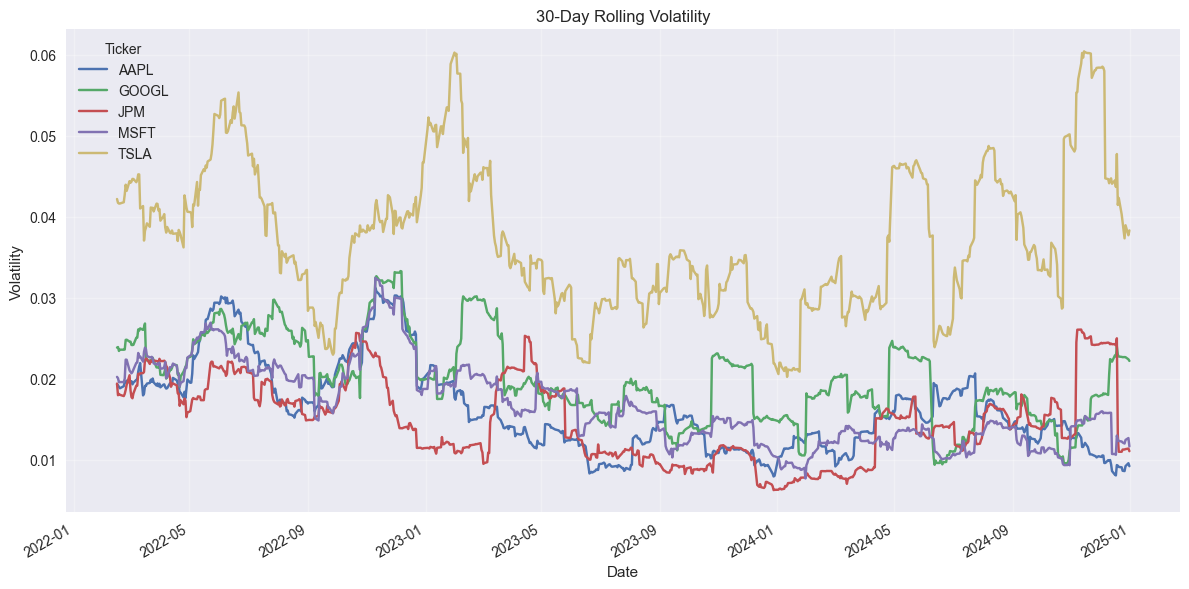

In [17]:
def plot_rolling_vol(df, window=30):
    """
    Plot rolling volatility for stock prices only.
    - Excludes non-price columns like SMA or technical indicators.
    - Shows Date properly on x-axis.
    """
    data = df.copy()

    # Ensure Date is set as index for proper plotting
    if 'Date' in data.columns:
        data = data.set_index('Date')

    # Select only stock price columns (exclude SMA, Buy/Sell, etc.)
    stock_cols = [col for col in data.columns if not col.startswith('SMA') and col not in ['Buy','Sell']]
    data = data[stock_cols]

    # Compute rolling volatility
    rolling_vol = data.pct_change().rolling(window=window).std()

    # Plot
    rolling_vol.plot(figsize=(12, 6), title=f"{window}-Day Rolling Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend(title="Ticker")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_rolling_vol(pivot, window=30)

In [ ]:
def annotate_profits_interactive(df, dates, prices, sma, save_folder="Graphs", filename="buy_sell_signals.html"):
    """
    Annotate buy/sell signals based on a Simple Moving Average (SMA) crossover strategy
    and plot them interactively with Plotly.

    Strategy:
        - Buy signal: when closing price crosses above the SMA.
        - Sell signal: when closing price crosses below the SMA.
        - Ignores repeated buy/sell signals until the opposite action occurs.

    Args:
        df (pd.DataFrame): DataFrame containing stock price and SMA data.
        dates (str): Column name in `df` representing dates.
        prices (str): Column name in `df` representing the closing price series.
        sma (str): Column name in `df` representing the SMA series.
        save_folder (str, optional): Folder path to save the interactive HTML chart.
            Defaults to "Graphs".
        filename (str, optional): Name of the output HTML file. 
            Defaults to "buy_sell_signals.html".

    Returns:
        None. Displays an interactive Plotly chart and saves it as an HTML file.

    Side Effects:
        - Adds two new columns to `df`: `Buy` and `Sell`, containing NaN except
          at buy/sell points where the closing price is stored.
        - Creates `save_folder` if it does not already exist.
        - Saves the interactive chart to the specified HTML file.

    """

    # Ensure folder exists
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    buy_signals = []
    sell_signals = []
    flag = -1  # -1: no position, 1: holding, 0: sold

    for i in range(len(df)):
        # Buy signal: Close crosses above SMA
        if df[prices].iloc[i] > df[sma].iloc[i]:
            if flag != 1:  # only buy if not already holding
                buy_signals.append(df[prices].iloc[i])
                sell_signals.append(np.nan)
                flag = 1
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)

        # Sell signal: Close crosses below SMA
        elif df[prices].iloc[i] < df[sma].iloc[i]:
            if flag != 0:  # only sell if holding
                buy_signals.append(np.nan)
                sell_signals.append(df[prices].iloc[i])
                flag = 0
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    df['Buy'] = buy_signals
    df['Sell'] = sell_signals

    fig = go.Figure()

    # Plot Close Price
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df[prices],
        mode='lines',
        name='Close Price',
        line=dict(color='blue', width=2),
        hovertemplate=(
            "<b>Close Price</b><br>" +
            "Date: %{x}<br>" +
            "Price: %{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Plot SMA line
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df[sma],
        mode='lines',
        name=sma,
        line=dict(color='orange', width=2, dash='dash'),
        hovertemplate=(
            "<b>Date</b>: %{x}<br>" +
            f"<b>{sma}</b>: " + "%{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Plot Buy signals
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df['Buy'],
        mode='markers',
        name='Buy Signal',
        marker=dict(symbol='triangle-up', color='green', size=12),
        hovertemplate=(
            "<b>Buy Signal</b><br>" +
            "Date: %{x}<br>" +
            "Price: %{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Plot Sell signals
    fig.add_trace(go.Scatter(
        x=df[dates],
        y=df['Sell'],
        mode='markers',
        name='Sell Signal',
        marker=dict(symbol='triangle-down', color='red', size=12),
        hovertemplate=(
            "<b>Sell Signal</b><br>" +
            "Date: %{x}<br>" +
            "Price: %{y:.2f}<br>" +
            "<extra></extra>"
        )
    ))

    # Layout
    fig.update_layout(
        title=dict(text="Stock Buy/Sell Signals Based on SMA Strategy", x = 0.5, font=dict(size=22)),
        xaxis_title="Date",
        yaxis_title="Price",
        template="plotly_white",
        width=1300,
        height=600,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=3, label="3m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all")
                ])
            ),
            # rangeslider=dict(visible=True),
            type="date",
            showgrid=True,
            gridcolor='lightgrey',
            tickangle=-45
        ),
        yaxis=dict(showgrid=True, gridcolor='lightgrey')
    )

    # Show interactive chart
    fig.show()

    # Save interactive HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")
    

In [ ]:
def plot_annual_risk_return_interactive(df, save_folder="Graphs", filename="annual_risk_return.html"):
    """
    Calculate annual risk (volatility) and annual return for each stock column in df
    and plot an interactive scatter plot with Plotly. Saves the chart as an HTML file.

    Args:
        df (pd.DataFrame): DataFrame containing stock prices with 'Date' column.
        save_folder (str): Folder to save the HTML file.
        filename (str): Name of the HTML file.S
    """
    returns = df.drop(columns=["Date"]).pct_change().dropna()

    summary = pd.DataFrame({
        "Annual Return": returns.mean() * 252,    # average daily return * trading days
        "Annual Risk": returns.std() * (252 ** 0.5)  # daily std * sqrt(trading days)
    })

    summary.reset_index(inplace=True)
    summary.rename(columns={"index": "Stock"}, inplace=True)

    # Add Sharpe Ratio for better insight
    summary["Sharpe Ratio"] = summary["Annual Return"] / summary["Annual Risk"]

    fig = px.scatter(
        summary,
        x="Annual Risk",
        y="Annual Return",
        text="Stock",
        size="Sharpe Ratio",   # bubble size indicates Sharpe Ratio
        color="Stock",
        hover_data=["Sharpe Ratio"],
        title="Annual Risk vs Return"
    )

    fig.update_traces(textposition="top center")
    fig.update_layout(
        width=900, 
        height=600,
        title=dict(text="Annual Risk vs Return",x=0.5, font=dict(size=22))
    )

    # Create folder if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Save HTML
    save_path = os.path.join(save_folder, filename)
    fig.write_html(save_path)
    print(f"Interactive chart saved to: {save_path}")

    # Show chart
    fig.show()


## 9) Save cleaned & pivot datasets
Choose to save your cleaned long-format and wide-format datasets to the `data/` folder so downstream modules can use them.


In [18]:
# Save (uncomment to write)
def save_outputs(cleaned_df, pivot_df, config):
    os.makedirs(os.path.dirname(config['output_long']), exist_ok=True)
    os.makedirs(os.path.dirname(config['output_wide']), exist_ok=True)
    
    # Save long-format dataset
    cleaned_df.to_csv(config['output_long'], index=False)
    print(f"Long-format dataset saved: {config['output_long']}")
    
    # Save wide-format dataset
    pivot_df.to_csv(config['output_wide'])
    print(f"Wide-format dataset saved: {config['output_wide']}")

# Example usage:
save_outputs(cleaned_data, pivot, CONFIG)


Long-format dataset saved: data/cleaned_stock_data_long.csv
Wide-format dataset saved: data/cleaned_stock_data_wide.csv


## 10) Presenter notes & suggested talking points
- Show the price series first and point out notable moves (dates).  
- Walk through SMA overlays to explain trend smoothing (mention window).  
- Use correlation heatmap to state which tickers move together.  
- Use boxplots & distribution plots to comment on skewness and fat tails.  
- Show outlier plots and explain methodology (Z-score vs IQR).  
- End with the data quality report (coverage %, missing %) to demonstrate robustness.
